<!-- # Calibration with GPU-optimized core functionalities -->

In [1]:
# Packages required for calibration
import numpy as np
import cupy as cp
import corrcal  # For performing the likelihood and gradient operations
from scipy.optimize import minimize  # For running calibration
# from torchmin import minimize


# Packages to help with covariance model building and simulation
import hera_sim
import matvis  # For coordinate transformations

hera_cal is not installed. Some gridding features unavailable.
pyfof is not installed. Some gridding features unavailable.


/home/mike/anaconda3/envs/corrcal_dev/lib/python3.13/site-packages/pyuvdata/analytic_beam.py:111: UserWarning: basis_vector_type was not defined, defaulting to azimuth and zenith_angle.
  warnings.warn(


In [2]:
from astropy import constants, units
from astropy.coordinates import Latitude, Longitude, AltAz
from astropy.coordinates import EarthLocation, SkyCoord
from astropy_healpix import HEALPix  # For interpolating to the image plane
from astropy.time import Time
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from pyradiosky import SkyModel
from pyuvdata import UVBeam  # If using a realistic beam model
from pyuvdata.analytic_beam import AiryBeam

In [3]:
import healpy  # For various operations on the sphere
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d  # For visualization purposes
# # %matplotlib inline

In [4]:

source_catalog = corrcal.DATA_PATH / "example_source_catalog.npz"
catalog_info = dict(np.load(source_catalog))
fluxes = catalog_info["fluxes"] * getattr(units, str(catalog_info["flux_unit"]))
ra = catalog_info["ra"] * getattr(units, str(catalog_info["ra_unit"]))
dec = catalog_info["dec"] * getattr(units, str(catalog_info["dec_unit"]))

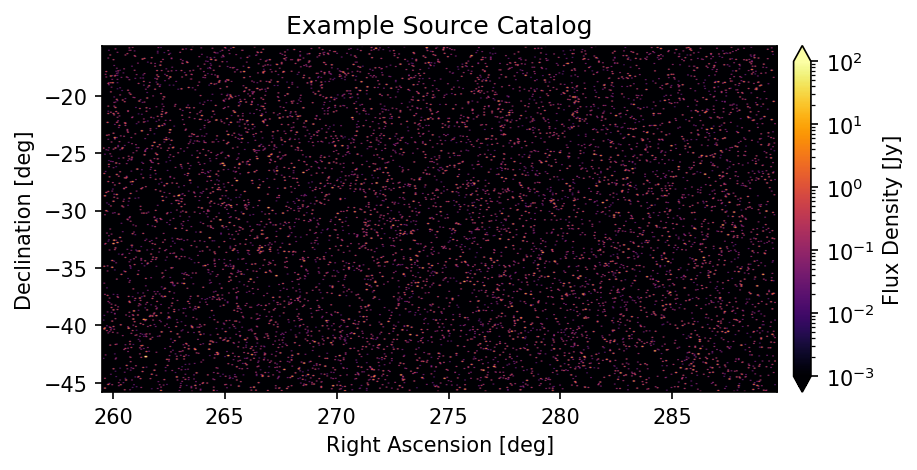

In [5]:
# Bin up the sources and plot the result to visualize the source catalog
buffer = 0.1 * units.deg
n_bins = 1025
ra_bounds = (
    (ra.min() - buffer).to(units.rad).value,
    (ra.max() + buffer).to(units.rad).value,
)
dec_bounds = (
    (dec.min() - buffer).to(units.rad).value,
    (dec.max() + buffer).to(units.rad).value,
)
ra_bins = np.linspace(*ra_bounds, n_bins+1)
dec_bins = np.linspace(*dec_bounds, n_bins+1)
binned_flux = binned_statistic_2d(
    ra.to(units.rad).value,
    dec.to(units.rad).value,
    fluxes.to(units.Jy).value,
    statistic="sum",
    bins=(ra_bins, dec_bins),
)[0]

# Smooth the binned flux to help with visualization.
kernel_width = 1 * units.arcmin.to(units.rad)
plot_ra = 0.5 * (ra_bins[1:]+ra_bins[:-1])
plot_ra -= plot_ra.mean()
plot_dec = 0.5 * (dec_bins[1:]+dec_bins[:-1])
plot_dec -= plot_dec.mean()
kernel = np.exp(
    -0.5 * plot_dec[:,None]**2 / kernel_width**2
) * np.exp(-0.5 * plot_ra[None,:]**2 / kernel_width**2)
smoothed_flux = np.abs(
    fftshift(ifft2(fft2(kernel) * fft2(binned_flux)))
)

# Now set up the plotting elements.
norm = plt.cm.colors.LogNorm(vmin=1e-3, vmax=1e2)
cmap = plt.cm.inferno.copy()
cmap.set_bad('k')
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
extent = np.array(ra_bounds + dec_bounds) * units.rad.to(units.deg)

# Finally, actually make the plot.
fig, ax = plt.subplots(1, 1, figsize=(7,3), dpi=150)
ax.set_xlabel("Right Ascension [deg]")
ax.set_ylabel("Declination [deg]")
ax.set_title("Example Source Catalog")
ax.imshow(smoothed_flux, origin="lower", aspect="auto", norm=norm, cmap=cmap, extent=extent)
fig.colorbar(smap, ax=ax, label="Flux Density [Jy]", extend="both", pad=0.02);

In [6]:
max_Tsky = 500 * units.K
# nside = 64
nside = 256  #use for hexconfig = 7

ell_max = 3*nside - 1
ells = np.arange(ell_max+1, dtype=float)
sky_pspec = 1 / (1+ells)**2
Tsky = healpy.synfast(sky_pspec, nside) * units.K
Tsky += np.abs(Tsky.min())  # Considering only emission and not absorption
Tsky *= max_Tsky / Tsky.max()

/home/mike/anaconda3/envs/corrcal_dev/lib/python3.13/site-packages/healpy/visufunc.py:200: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  f = pylab.figure(fig, figsize=(8.5, 5.4))


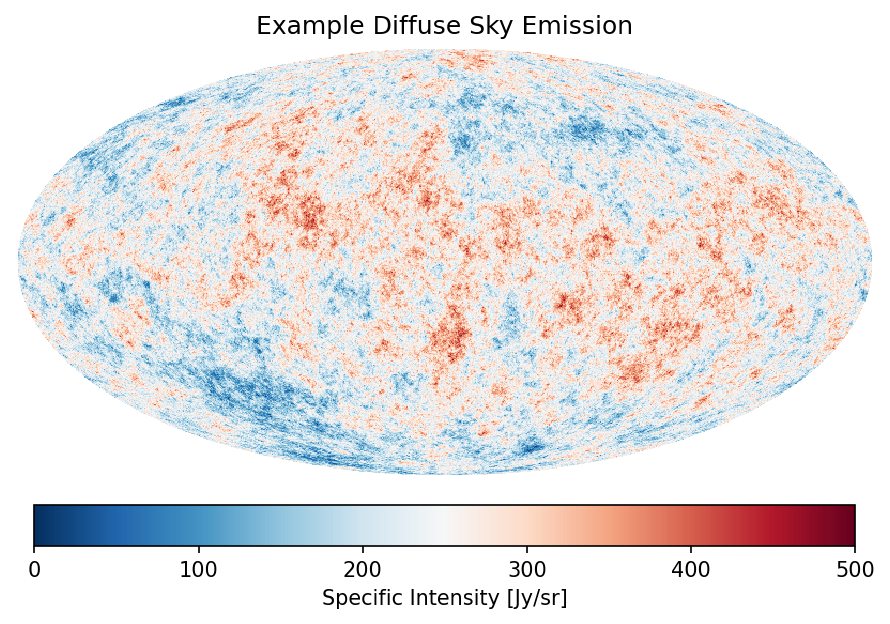

In [7]:
# Quickly visualize the diffuse component
plt.figure(figsize=(6,4), dpi=150)
healpy.mollview(
    Tsky.value,
    fig=1,
    title="",
    cmap="RdBu_r",
    cbar=False,
    norm=None,
    min=Tsky[Tsky>0].min().value,
    max=Tsky.max().value,
)

# Manually make the colorbar and title
norm = plt.cm.colors.Normalize(vmin=0, vmax=Tsky.max().value)
cmap = plt.cm.RdBu_r
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(
    smap,
    ax=plt.gca(),
    orientation="horizontal",
    label="Specific Intensity [Jy/sr]",
    shrink=0.95,
    pad=0.05,
)
plt.title("Example Diffuse Sky Emission");

In [8]:

# Required parameters for making a UVData object
obstime = 2459917.00243  # Julian date
integration_time = 10  # seconds
Ntimes = 1
freq = 150e6  # Hz
channel_width = 100e3  # Hz
Nfreqs = 1
polarizations = ["xx",]
array_layout = hera_sim.antpos.hex_array(7, outriggers=0, split_core=False)
latitude = -30.721527099609585  # Degrees
longitude = 21.42830467224121  # Degrees
altitude = 1073.0000000121072  # Meters
# Additional information.
diameter = 14

In [9]:
# Create the UVData object.
src_uvdata = hera_sim.io.empty_uvdata(
    Ntimes=Ntimes,
    start_time=obstime,
    integration_time=integration_time,
    Nfreqs=Nfreqs,
    start_freq=freq,
    channel_width=channel_width,
    array_layout=array_layout,
    polarizations=polarizations,
    telescope_location=[latitude, longitude, altitude],
)
# For sanity checks later.
diff_uvdata = src_uvdata.copy()

The default baseline conjugation convention has changed. In the past it was 'ant2<ant1', it now defaults to 'ant1<ant2'. You can specify the baseline conjugation convention in `obs_param` by setting the obs_param['ordering']['conjugation_convention'] field. This warning will go away in version 1.5.


In [10]:
# Create the beam model.
beam = AiryBeam(diameter=diameter)
# beam = AnalyticBeam("airy", diameter=14)
beam_ids = [0,] * src_uvdata.Nants_data

In [11]:
# Generate the SkyModel for the source catalog.
source_stokes = np.zeros((4, 1, fluxes.size), dtype=float) * units.Jy
source_stokes[0,0] = fluxes
source_model = SkyModel(
    name=np.arange(fluxes.size).astype(str),
    ra=Longitude(ra),
    dec=Latitude(dec),
    stokes=source_stokes,
    spectral_type="flat",  # No spectral evolution
    component_type="point",
    frame="icrs",
    freq_array=np.array([freq])*units.Hz,
)

In [12]:
# Generate the SkyModel for the diffuse emission.
diffuse_stokes = np.zeros((4, 1, Tsky.size), dtype=float) * units.K
diffuse_stokes[0,0] = Tsky
diffuse_model = SkyModel(
    stokes=diffuse_stokes,
    hpx_inds=np.arange(Tsky.size),
    spectral_type="flat",
    component_type="healpix",
    nside=nside,
    frame="icrs",
    freq_array=np.array([freq])*units.Hz,
)

In [13]:
# Simulate the diffuse visibilities.
data_model = hera_sim.visibilities.ModelData(
    uvdata=diff_uvdata,
    sky_model=diffuse_model,
    beams=[beam,],
    beam_ids=beam_ids,
)
simulation = hera_sim.visibilities.VisibilitySimulation(
    data_model=data_model,
    simulator=hera_sim.visibilities.MatVis(),
)
simulation.simulate();

In [14]:
# Simulate the point source visibilities.
data_model = hera_sim.visibilities.ModelData(
    uvdata=src_uvdata,
    sky_model=source_model,
    beams=[beam,],
    beam_ids=beam_ids,
)
simulation = hera_sim.visibilities.VisibilitySimulation(
    data_model=data_model,
    simulator=hera_sim.visibilities.MatVis(),
)
simulation.simulate();

In [15]:
uvdata = src_uvdata.copy()
uvdata.data_array += diff_uvdata.data_array

In [16]:

# Choosing this as the minimum baseline length more strongly enforces the
# approximation that there is no shared information between different redundant
# groups sourced from diffuse emission.
min_bl_length = np.sqrt(2) * diameter
min_group_size = 5  # This is somewhat arbitrary, but helps with computational cost
ant_1_array, ant_2_array, edges = corrcal.gridding.make_groups_from_uvdata(
    uvdata, min_bl_len=min_bl_length, min_group_size=min_group_size
)

The use_grid_alg parameter is not set. Defaulting to True to use the new gridding based algorithm (developed by the HERA team) rather than the older clustering based algorithm. This is change to the default, to use the clustering algorithm set use_grid_alg=False.


In [17]:
enu_antpos = uvdata.get_ENU_antpos()[0]
za, az = healpy.pix2ang(nside, np.arange(healpy.nside2npix(nside)))

In [18]:
# Construct the AltAz frame for coordinate transformations.
observatory = EarthLocation(longitude, latitude, altitude)
local_frame = AltAz(location=observatory, obstime=Time(obstime, format="jd"))

In [19]:
# The diffuse emission needs to be converted from K to Jy
diffuse_model.kelvin_to_jansky()
Tsky = diffuse_model.stokes[0,0].value

In [20]:
from astropy_healpix import HEALPix
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, sph_harm_y

# Prepare the direction cosine grid.
uvws = freq * (
    enu_antpos[ant_2_array] - enu_antpos[ant_1_array]
) / constants.c.si.value
u_max = np.linalg.norm(uvws, axis=1).max()
n_l = int(8 * u_max)
if n_l % 2 == 0:
    n_l += 1  # Ensure we get (l,m) = (0,0)
lm_grid = np.linspace(-1, 1, n_l)
LM = np.array(np.meshgrid(lm_grid, lm_grid))
measure = np.diff(lm_grid)[0] ** 2

# Put the sky onto the (l,m) grid.
flat_Tsky = np.zeros((n_l,n_l), dtype=float)
hpx_grid = HEALPix(nside=nside, order="ring", frame="icrs")
for row, m in enumerate(lm_grid):
    # Choose only pixels that are above the horizon.
    lmag = np.sqrt(m**2 + lm_grid**2)
    select = lmag < 1 - 1e-2  # Buffer to avoid small divide issues.
    if select.sum() == 0:
        continue

    # Compute the azimuth and zenith angle for each point.
    indices = np.argwhere(select).flatten()
    za = np.arcsin(lmag[select])
    az = np.arctan2(m, lm_grid[select])

    # Interpolate the sky onto the image plane.
    coords = SkyCoord(
        Longitude(np.pi/2 - az, unit="rad"),  # astropy uses E of N
        Latitude(np.pi/2 - za, unit="rad"),
        frame=local_frame,
    ).transform_to("icrs")
    flat_Tsky[row,select] = hpx_grid.interpolate_bilinear_skycoord(
        coords, Tsky
    ) / np.sqrt(1 - lmag[select]**2)  # Apply flat sky projection.

sky_pspec = np.abs(
    np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(flat_Tsky * measure)))
) ** 2

In [21]:
# Cylindrically average the sky power and form bandpower interpolator.
u_modes = 0.5 * (1 + np.arange(-n_l//2, n_l//2))
u_mag = np.linalg.norm(np.array(np.meshgrid(u_modes, u_modes)), axis=0)
u_bins = np.linspace(0, u_modes.max(), n_l//4)
binned_pspec = binned_statistic(
    u_mag.flatten(), sky_pspec.flatten(), statistic="mean", bins=u_bins
)[0]
pspec_interp = interp1d(
    0.5 * (u_bins[1:]+u_bins[:-1]),
    binned_pspec * (u_bins[1]-u_bins[0]),
    kind="cubic",
    bounds_error=False,
    fill_value="extrapolate",
)

In [22]:
# Prepare some auxiliary parameters for computing covariance elements.
# nside = 64
lmax = 6  # We won't need more Bessel functions than this.
ells, emms = healpy.Alm.getlm(lmax)
ells = ells[:,None,None]
emms = emms[:,None,None]  # Conform shapes for later calculations.
zero_m = emms[:,0,0] == 0
pixels = np.arange(healpy.nside2npix(nside))
bm_thetas, bm_phis = healpy.pix2ang(nside, pixels)
hpx_bsq_vals = beam.power_eval(
    az_array=bm_phis,
    za_array=bm_thetas,
    freq_array=np.array([freq]),
)[0][0,0].real ** 2
if hpx_bsq_vals.ndim == 3:
    hpx_bsq_vals = hpx_bsq_vals[0,0]
hpx_bsq_vals[bm_thetas>np.pi/2] = 0  # Horizon cut.
Blm = healpy.map2alm(
    hpx_bsq_vals,
    use_pixel_weights=True,
    lmax=lmax,
)[:,None,None]

In [23]:
# Now compute the diffuse matrix.
n_eig = 1  # You can experiment with this
diff_mat = np.zeros((edges[-1], 2*n_eig), dtype=float)
for start, stop in zip(edges, edges[1:]):
    # Compute amplitude of baseline deviations within the group.
    uvw_here = uvws[start//2:stop//2]
    uvw_diffs = uvw_here[:,None] - uvw_here[None]
    uvw_diff_mags = np.linalg.norm(uvw_diffs, axis=2)

    # Get orientations of baseline differences.
    normed_uvw_diffs = uvw_diffs / np.where(
        uvw_diff_mags > 0, uvw_diff_mags, 1
    )[:,:,None]
    thetas = np.arccos(normed_uvw_diffs[:,:,2])[None,:,:]
    phis = np.arctan2(
        normed_uvw_diffs[:,:,1], normed_uvw_diffs[:,:,0]
    )[None,:,:]

    # Compute the covariance for this block.
    band_power = pspec_interp(np.linalg.norm(uvw_here.mean(axis=0)))
    bessels = spherical_jn(ells, 2*np.pi*uvw_diff_mags[None,:,:])
    Ylms = sph_harm_y(ells, emms, thetas, phis)
    flm = 1j**ells * bessels * Ylms
    offset = np.sum(flm[zero_m] * Blm[zero_m], axis=0)
    B_kk = np.sum(
        flm*Blm + (-1)**ells * flm.conj() * Blm.conj(), axis=0
    ) - offset

    # Fill in the real/imaginary block covariance.
    block = np.zeros(2*np.array(B_kk.shape), dtype=float)
    block[::2,::2] = B_kk.real
    block[1::2,1::2] = B_kk.real
    block[1::2,::2] = B_kk.imag
    block[::2,1::2] = -B_kk.imag
    block *= 0.5 * band_power

    # Now take the eigendecomposition.
    eigvals, eigvecs = np.linalg.eigh(block)
    sort = np.argsort(eigvals.real)[::-1]
    eigvals = eigvals[sort][:2*n_eig]
    eigvecs = eigvecs[:,sort][:,:2*n_eig]
    block = np.sqrt(eigvals)[None,:] * eigvecs
    diff_mat[start:stop] = np.where(np.isnan(block), 0, block)

In [24]:
# Compute source matrix. First, figure out local source positions.

source_positions = SkyCoord(
    Longitude(ra), Latitude(dec), frame="icrs"
).transform_to(local_frame)

# Now downselect to calibration candidates.
above_horizon = source_positions.alt > 0
near_zenith = source_positions.alt.deg > 80
is_bright = fluxes > 100*units.Jy  # Fluxes are assumed to be in Jy.
select = near_zenith | (is_bright & above_horizon)
src_az = Longitude(
    np.pi/2*units.rad - source_positions.az
)[select].to(units.rad).value
src_za = np.pi/2 - source_positions.alt.rad[select]
src_flux = fluxes[select]

# Compute the beam at each source position.
src_beam_vals = beam.power_eval(
    az_array=src_az,
    za_array=src_za,
    freq_array=np.array([freq]),
)[0][0,0]
if src_beam_vals.ndim == 2:
    src_beam_vals = src_beam_vals[0]

# Now convert that to an observed flux with matvis Stokes convention.
# You can change the scale to add fractional errors on source fluxes.
flux_err = np.random.normal(
    loc=1, scale=0, size=src_flux.size
)
src_fluxes = 0.5 * src_flux * src_beam_vals * flux_err

# Now figure out which sources to keep for calibration.
n_src = 5 # You can experiment with this
sort = np.argsort(src_fluxes)[::-1]  # Sort from highest to lowest flux.
src_az = src_az[sort][:n_src]
src_za = src_za[sort][:n_src]
src_flux = src_fluxes[sort][:n_src]

# Finally, actually compute the source matrix.
uvws = freq * (
    enu_antpos[ant_2_array] - enu_antpos[ant_1_array]
) / constants.c.si.value
src_nhat = np.array(
    [
        np.sin(src_za)*np.cos(src_az),
        np.sin(src_za)*np.sin(src_az),
        np.cos(src_za),
    ]
)
src_fringe = np.exp(-2j * np.pi * uvws @ src_nhat)
src_vis = src_flux[None,:] * src_fringe
src_mat = np.zeros((edges[-1], n_src), dtype=float)
src_mat[::2] = src_vis.real
src_mat[1::2] = -src_vis.imag

In [25]:
# Now do a quick check that the amplitude of the diffuse matrix makes sense
diff_data = np.array(
    [
        diff_uvdata.get_data(ai,aj,'xx')[0,0]
        for ai, aj in zip(ant_1_array, ant_2_array)
    ]
)

In [26]:
# Now do a quick sanity check
src_data = np.array(
    [
        src_uvdata.get_data(ai,aj,'xx')[0,0]
        for ai, aj in zip(ant_1_array, ant_2_array)
    ]
)

<!-- ## Run Calibration

#### Sorting into redundant groups -->

In [27]:
# Now we can use these arrays to retrieve the data.
data = np.array(
    [
        uvdata.get_data(ai, aj, "xx").flatten()[0]
        for ai, aj in zip(ant_1_array, ant_2_array)
    ]
)

<!-- #### Noise Estimation -->

In [28]:

autocorr = uvdata.get_data(0, 0, "xx")[0,0].real
noise_amp = 1e-4 * autocorr  # This is radiometer with dnu dt = 1e8
noise = np.ones(2*ant_1_array.size, dtype=float) * noise_amp

In [29]:

# Choose some gain parameters
gain_amp = 1
amp_jitter = 0.1  # 10% jitter in the true gain amplitudes
amp_error = 0.1  # 10% errors in the initial guesses for the gains
phs_error = 0.05  # average error on the gain phase, in radians

# Simulate the gains
n_ants = uvdata.Nants_data
gain_amplitudes = np.random.normal(
    size=n_ants, loc=gain_amp, scale=amp_jitter
)
gain_phases = np.random.uniform(0, 2*np.pi, n_ants)
true_gains = gain_amplitudes * np.exp(1j*gain_phases)

# Now take a perturbation on the true gains as the initial guess
init_amp = gain_amplitudes * np.random.normal(
    size=n_ants, loc=1, scale=amp_error
)
init_phs = gain_phases + np.random.normal(
    size=n_ants, loc=0, scale=phs_error
)
init_gains = init_amp * np.exp(1j*init_phs)

In [30]:
# Now apply the gains to the data.
data *= true_gains[ant_1_array] * true_gains[ant_2_array].conj()

In [31]:
data_reim = np.zeros((2*len(data)))
data_reim[::2] = data.real
data_reim[1::2] = data.imag

### Run Calibration

In [32]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import cupy as cp
from optimize import *

In [33]:
# Create the sparse covariance object.
cov = corrcal.sparse.SparseCov(
    noise=noise,
    diff_mat=diff_mat,
    src_mat=src_mat,
    edges=edges,
    n_eig=2*n_eig,
    isinv=False,
)

In [34]:
# Set up the additional arguments the objective function needs.
gain_scale = 1  # Scaling factor to help with convergence time.
phs_norm = 0.1  # How close to zero phase the calibration solutions should be.

cpu_opt_args = (
    cov, data_reim, ant_1_array, ant_2_array, gain_scale, phs_norm
)

gpu_opt_args = (
    noise, diff_mat, src_mat, edges, data_reim, n_ants, ant_1_array, ant_2_array, gain_scale, phs_norm
)

In [35]:
# Split up the gains into the real/imaginary parts for calibration.
split_gains = np.zeros(2*n_ants, dtype=float)

split_gains[::2] = init_gains.real
split_gains[1::2] = init_gains.imag

In [45]:
# Now run the optimization.
result = minimize(
    corrcal.optimize.nll,
    gain_scale*split_gains,
    args=cpu_opt_args,
    method="CG",  # Use the conjugate-gradient solver
    jac=corrcal.optimize.grad_nll,
    options=dict(retall=True),
)


Unknown solver options: retall


In [48]:
# Now run the optimization.
result = minimize(
    cal_gpu_nll,
    gain_scale*split_gains,
    args=gpu_opt_args,
    method="CG",  # Use the conjugate-gradient solver
    jac=cal_gpu_grad_nll,
    options=dict(retall=True),
)


Unknown solver options: retall


In [38]:
# CORRCAL
gain_soln = corrcal.utils.rephase_to_ant(
    result.x[::2] + 1j*result.x[1::2], 0
)
true_gains = corrcal.utils.rephase_to_ant(true_gains, 0)


In [39]:

rescaling = np.abs(true_gains).mean() / np.abs(gain_soln).mean()
gain_soln *= rescaling

fit_gain_mat = gain_soln[ant_1_array] * gain_soln[ant_2_array].conj()
true_gain_mat = true_gains[ant_1_array] * true_gains[ant_2_array].conj()
phs_errs = np.angle(fit_gain_mat * true_gain_mat.conj())
bls = enu_antpos[ant_2_array,:2] - enu_antpos[ant_1_array,:2]
M = np.linalg.inv(bls.T @ bls) @ bls.T
phs_grad = M @ phs_errs
rephased_gain_soln = gain_soln * np.exp(1j * enu_antpos[:,:2] @ phs_grad)
rephased_gain_soln *= np.exp(-1j*np.angle(rephased_gain_soln[0]))

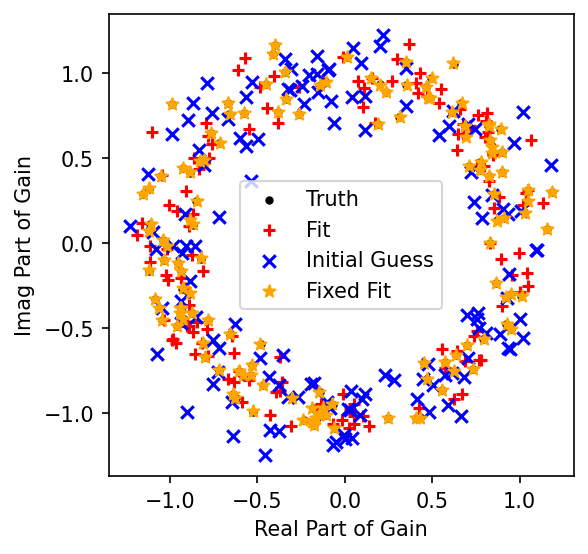

In [50]:

# First, let's look at the gain solutions in the complex plane.
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=150)
ax.set_xlabel("Real Part of Gain")
ax.set_ylabel("Imag Part of Gain")

ax.scatter(true_gains.real, true_gains.imag, color="k", marker=".", label="Truth")
ax.scatter(gain_soln.real, gain_soln.imag, color="r", marker="+", label="Fit")
ax.scatter(init_gains.real, init_gains.imag, color="b", marker="x", label="Initial Guess")
ax.scatter(rephased_gain_soln.real, rephased_gain_soln.imag, color="orange", marker="*", label="Fixed Fit")

ax.legend();


In [41]:
#CUPY
edges = cp.asnumpy(edges)

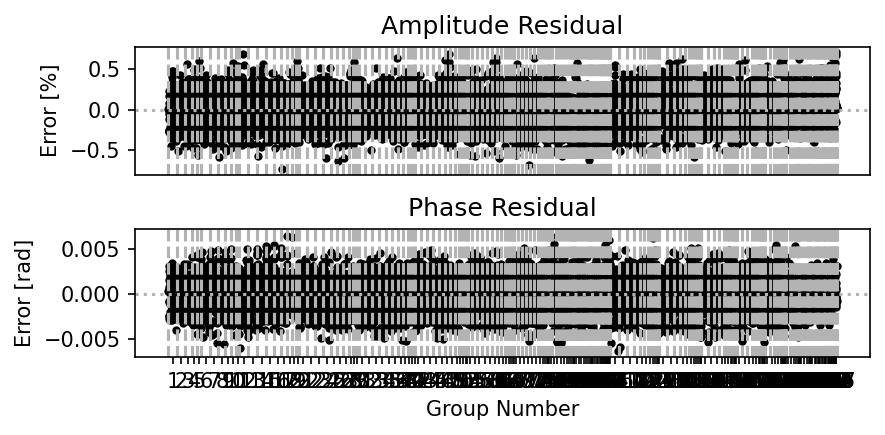

In [42]:
# Now let's look at the calibrated data.
fig, axes = plt.subplots(2, 1, figsize=(6,3), dpi=150)
axes[1].set_xlabel("Group Number")
axes[0].set_title("Amplitude Residual")
axes[1].set_title("Phase Residual")
axes[0].set_ylabel("Error [%]")
axes[1].set_ylabel("Error [rad]")

true_data = np.array(
    [
        uvdata.get_data(ai, aj, "xx")[0,0]
        for ai, aj in zip(ant_1_array, ant_2_array)
    ]
)

true_gain_mat = true_gains[ant_1_array] * true_gains[ant_2_array].conj()
fit_gain_mat = rephased_gain_soln[ant_1_array] * rephased_gain_soln[ant_2_array].conj()
cal_data = true_data * true_gain_mat / fit_gain_mat

amp_resid = 100 * (
    np.abs(cal_data) - np.abs(true_data)
) / np.abs(true_data)

phs_resid = np.angle(true_data * cal_data.conj())

axes[0].plot(
    0.5 + np.arange(ant_1_array.size), amp_resid, color="k", marker=".", lw=0
)
axes[1].plot(
    0.5 + np.arange(ant_1_array.size), phs_resid, color="k", marker=".", lw=0
)

for ax in axes:
    ax.axhline(0, color="0.7", ls=":")
    for edge in edges:
        ax.axvline(edge/2, color="0.7", ls="--")

axes[1].set_xticks(0.25 * (edges[1:] + edges[:-1]))
axes[1].set_xticklabels(range(1,len(edges)))        
axes[0].xaxis.set_visible(False)
fig.tight_layout();

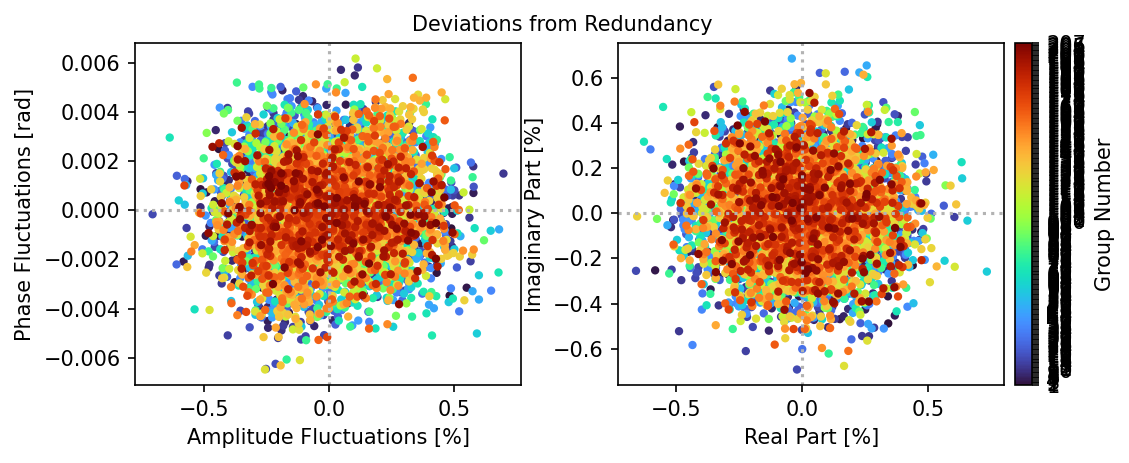

In [43]:
# Now let's look at fluctuations about the redundant average for each group.
amp_fluctuations = np.zeros(cal_data.size, dtype=float)
phs_fluctuations = np.zeros(cal_data.size, dtype=float)
vis_fluctuations = np.zeros(cal_data.size, dtype=complex)
group_ids = np.zeros(cal_data.size, dtype=float)

for i, (start, stop) in enumerate(zip(edges//2, edges[1:]//2), 1):
    group = cal_data[start:stop]
    red_avg = group.mean()
    amp_fluctuations[start:stop] = 100 * (
        np.abs(group) - np.abs(red_avg)
    ) / np.abs(red_avg)
    phs_fluctuations[start:stop] = np.angle(group * red_avg.conj())
    group_ids[start:stop] = i
    vis_fluctuations[start:stop] = 100 * (
        group - red_avg
    ) / np.abs(red_avg)
    
# print(vis_fluctuations)

fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=150)
axes[0].set_xlabel("Amplitude Fluctuations [%]")
axes[0].set_ylabel("Phase Fluctuations [rad]")
axes[1].set_xlabel("Real Part [%]")
axes[1].set_ylabel("Imaginary Part [%]")
fig.text(0.475, 0.99, "Deviations from Redundancy", ha="center", va="center")
for ax in axes:
    ax.axvline(0, color='0.7', ls=':')
    ax.axhline(0, color='0.7', ls=':')
    
axes[1].scatter(vis_fluctuations.real, vis_fluctuations.imag, c=group_ids, marker='.', cmap=plt.cm.turbo)
cax = axes[0].scatter(amp_fluctuations, phs_fluctuations, c=group_ids, marker='.', cmap=plt.cm.turbo)

fig.tight_layout()
cbar = fig.colorbar(cax, ax=axes, label="Group Number", pad=0.01)
cbar.set_ticks(np.arange(1, edges.size))

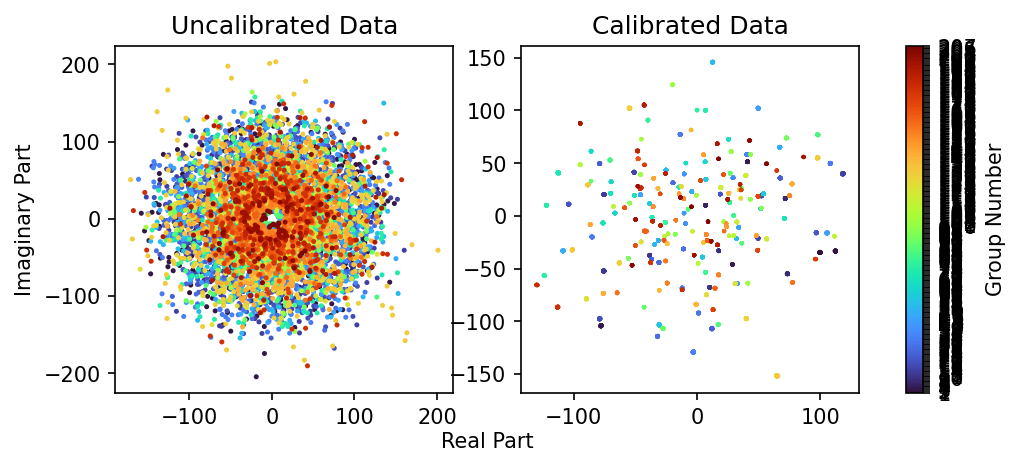

In [44]:

# To help put things into context, let's compare against uncalibrated data
uncal_data = true_gain_mat * true_data
plot_kwds = dict(
    c=group_ids,
    cmap=plt.cm.turbo,
)
fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=150)
fig.text(0.435, 0, "Real Part", ha="center", va="center")
axes[0].set_ylabel("Imaginary Part")
axes[0].set_title("Uncalibrated Data")
axes[1].set_title("Calibrated Data")
axes[0].scatter(uncal_data.real, uncal_data.imag, s=2, **plot_kwds)
cax = axes[1].scatter(cal_data.real, cal_data.imag, s=1, **plot_kwds)
cbar = fig.colorbar(cax, ax=axes, label="Group Number")
cbar.set_ticks(np.arange(1, edges.size));